In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd

In [2]:
def get_obs_list():
    obstacles = r'C:\Users\pwu154371\Desktop\Robotics Assignments\Planning_coursera\planning_coursera\obstacles.csv'
    obstacleList = pd.read_csv(obstacles, skiprows = 3) 
    obs_list = []
    for i in range(len(obstacleList)):
        t = (round(float(obstacleList.iloc[i,0]),2),round(float(obstacleList.iloc[i,1]),2),round(float(obstacleList.iloc[i,2]*0.5),2))
        obs_list.append(t)
    return obs_list

In [5]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

show_animation = True


class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y, index = None):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None
            self.index = index

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=0.25,
                 path_resolution=0.125,
                 goal_sample_rate=5,
                 max_iter=500):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        """
        self.start = self.Node(start[0], start[1], 1)
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.edge_list = []
        self.path_idx = []

    def planning(self, animation=True):
        """
        rrt path planning
        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_collision(new_node, self.obstacle_list):
                new_node.index = len(self.node_list)+1
                self.node_list.append(new_node)
                self.edge_list.append((nearest_node.index, new_node.index))

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end, self.expand_dis)
                if self.check_collision(final_node, self.obstacle_list):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        self.path_idx.append(len(self.node_list)+1)
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            self.path_idx.append(node.index)
            node = node.parent
        path.append([node.x, node.y])
        self.path_idx.append(node.index)

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([-0.5, 0.5, -0.5, 0.5])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_collision(node, obstacleList):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= size**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

start 


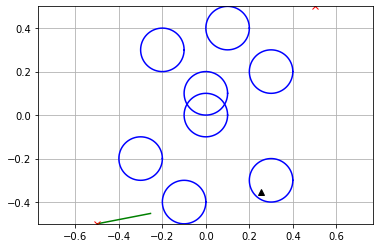

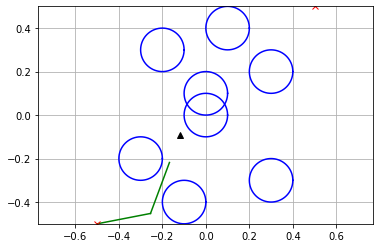

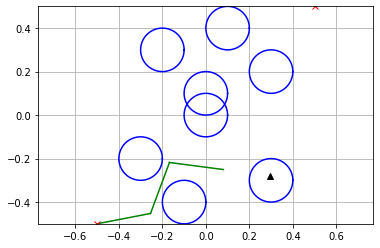

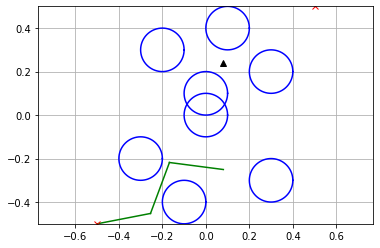

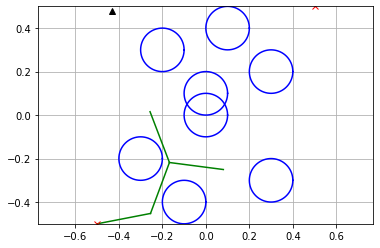

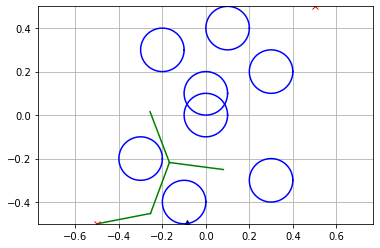

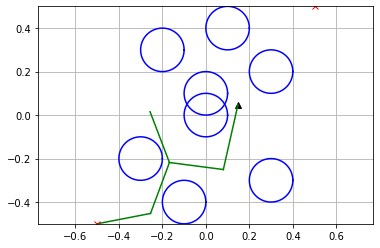

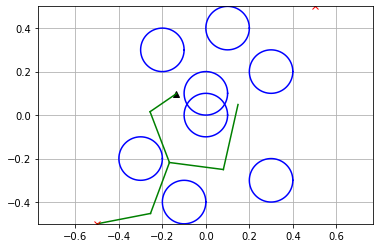

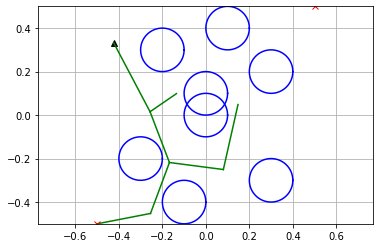

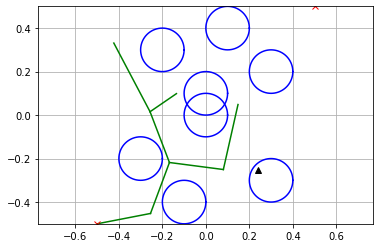

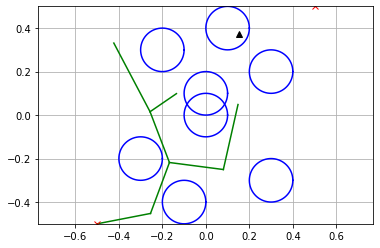

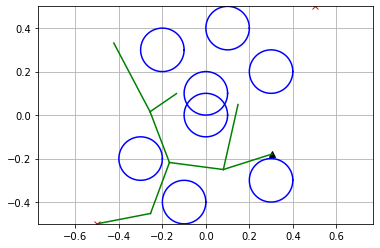

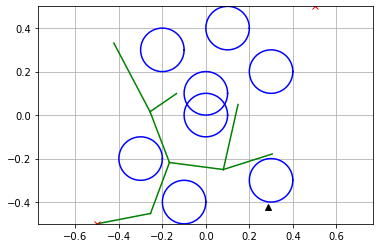

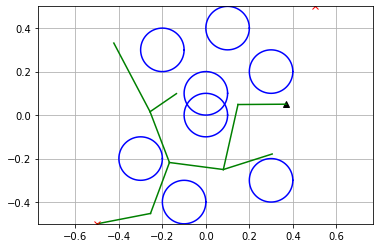

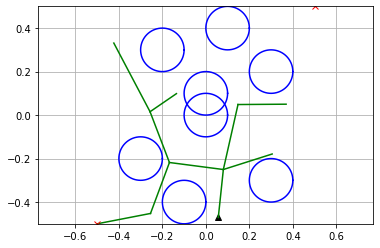

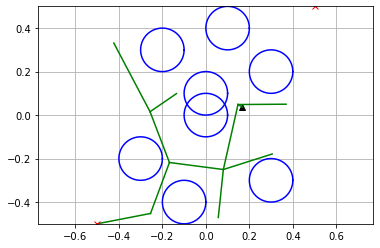

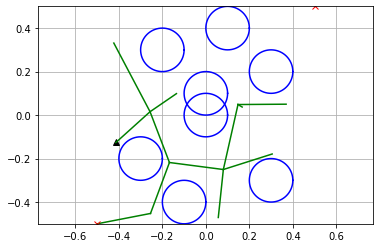

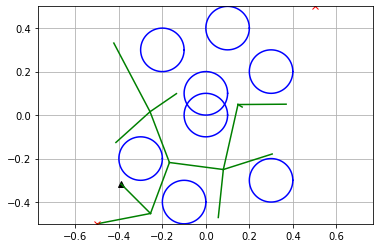

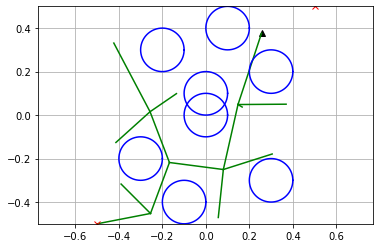

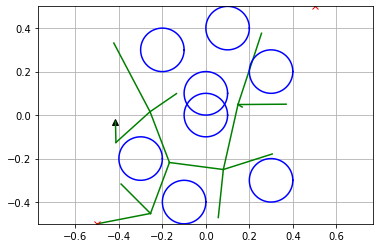

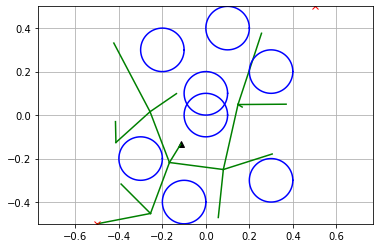

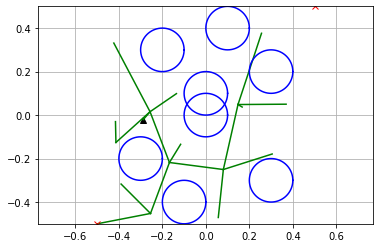

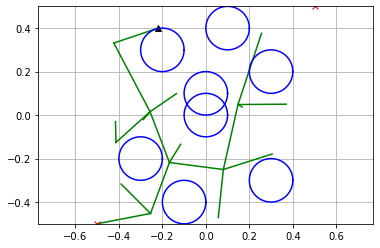

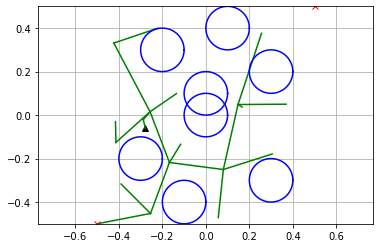

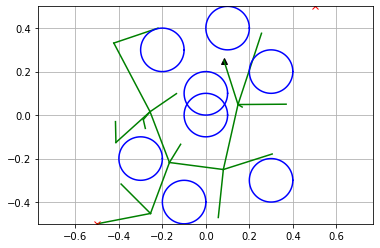

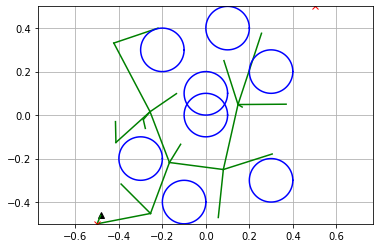

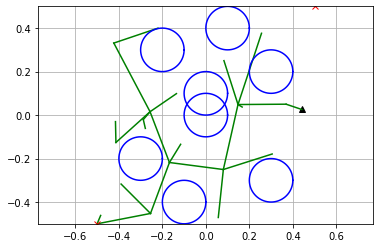

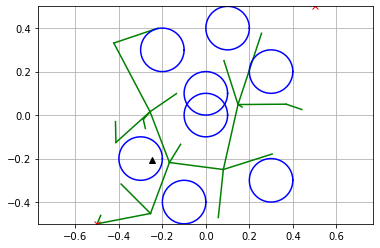

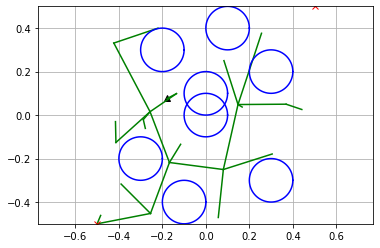

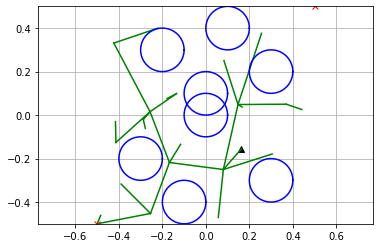

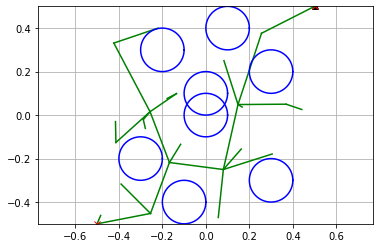

found path!!


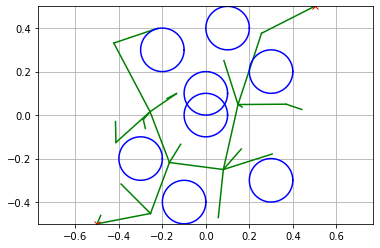

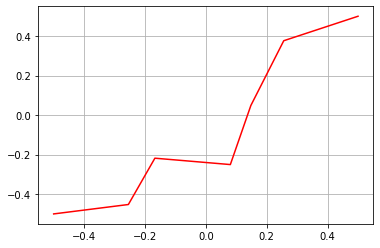

In [6]:
path_idx = None
edge_list = None
node_list = None

print("start ")
# ====Search Path with RRT====
obstacleList = get_obs_list()  # [x, y, radius]
# Set Initial parameters
rrt = RRT(
    start=[-0.5, -0.5],
    goal=[0.5, 0.5],
    rand_area=[-0.5, 0.5],
    obstacle_list=obstacleList)
path = rrt.planning(animation=show_animation)

path_idx = rrt.path_idx
edge_list = rrt.edge_list
node_list = rrt.node_list


if path is None:
    print("Cannot find path")
else:
    print("found path!!")

    # Draw final path
    if show_animation:
        rrt.draw_graph()
        plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
        plt.grid(True)
        #plt.pause(0.01)  # Need for Mac
        plt.show()

In [ ]:
path = open(r'C:\Users\pwu154371\Desktop\Robotics Assignments\Planning_coursera\planning_coursera\path.csv', 'w')
path_idx.reverse()
with path:

    writer = csv.writer(path)
    writer.writerow(path_idx)

In [ ]:
edge = open(r'C:\Users\pwu154371\Desktop\Robotics Assignments\Planning_coursera\planning_coursera\edges.csv', 'w', newline = '')
with edge:
    writer = csv.writer(edge)
    writer.writerow(('#id1','id2','cost'))
    for edge in edge_list:
        writer.writerow((edge[0],edge[1],0))
    writer.writerow((path_idx[-2],path_idx[-1],0)) # append the last edge

In [ ]:
node = open(r'C:\Users\pwu154371\Desktop\Robotics Assignments\Planning_coursera\planning_coursera\nodes.csv', 'w', newline = '')
with node:
    writer = csv.writer(node)
    writer.writerow(('#id','x','y','cost'))
    for node in node_list:
        writer.writerow((node.index,node.x,node.y,0))
    writer.writerow((len(node_list)+1,0.5,0.5,0)) # append the last node